# Konnektor - Building Ligand Networks
******************************************************



this is Konnektor! You can use to construct different types of Networks. We designed Konnektor especially in context with Free Energy Calculations in mind, allowing to setup plans for calculating campaigns, that could be for example useful for drug discovery research.
Nevertheless, Konnektor is based on graph theory. So we are looking forward to the many different use cases.

Content of this Notebook:
* [Simple Network Examples](#Simple-Network-Example)
* [Using Real World Data](#Using-Real-World-Data)
* [Advanced Network Generation](#Advanced-Network-Generation)


In [ ]:
# NBVAL_SKIP
# Only run this cell if on google colab
import os

if "COLAB_RELEASE_TAG" in os.environ:
    !pip install -U https://github.com/conda-incubator/condacolab/archive/cuda-version-12.tar.gz
    import condacolab

    condacolab.install_mambaforge()
    !wget -q https://raw.githubusercontent.com/OpenFreeEnergy/konnektor/main/examples/environment.yaml
    !mamba env update -q --name=base --file=environment.yaml

from google.colab import output

output.enable_custom_widget_manager()

## 1. Simple Network Examples
----------------------------------------

In this section we will have a first look on the basic functionality of Konnektor. We will show you how to construct networks. For a more detailed look on the Networks, please have a look at the konnektor_networks notebook.

### Build up randomized data:
First we will generate a randomized dataset of Molecules (`Component`s), with a specific for this dataset generated `AtomMapper` and `AtomMappingScorer`. The `AtomMapper` in our case is a "edge generator" allowing to build up all possible edges for the set of `Component`s. The `AtomMappingScorer` simply adds the weight information to the generated edges in theory based on the estimate on how difficult the transformation of `Component` A to `Component` B is. As a result, the resulting `AtomMapping`s can be used in a graph construction approach, trying to find the best transformation path through all molecules, allowing an all to all comparison.


In [1]:
from konnektor.utils import toy_data

components, mapper, combo_scorer = toy_data.build_random_dataset(
    n_compounds=20, rand_seed=42
)

### Star Network Layout
The  __Star Network Layout__  is a very simple network layout, which is relative efficient on the required calculation ammount and relativly robust for maintaining a large amount of `Component` comparisons if an `Transformation` failS during their calculation.However it is not optimal, in the context of optimizing the overall graph cost, as one central `Component` needs to be selected and that is always a compromise between all the possible `Components`

Now let's build our first Network. The __Star Network Layout__ can be very easily generated using the `StarNetworkGenerator`.
As settings to build the generator, the `AtomMapper` and the `AtomMappingScorer` are required to build the possible edges and their associated weights. This concept will repeat for all the network generators in Konnektor. With the `n_processes` flag the underlying implementation can be parallelized onto multiple CPUs.


In [2]:
from konnektor.network_planners import StarNetworkGenerator

network_planner = StarNetworkGenerator(
    mapper=mapper, scorer=combo_scorer, n_processes=1
)

Next the network is generated using the instance of the `StarNetworkGenerator`. For ease of use, we add a name to the generated object. Note in this approach the `StarNetworkGenerator` is selecting the central `Component` itself, by finding the average best score-performing `Component`. You could also pass your own desired central `Component` using `central_component` in the network generation call.


In [3]:
radial_network = network_planner(components)
radial_network.name = "Star Network"
radial_network

<LigandNetwork-9cbd6ab784dd61c6490979fdb3f97c92>

Finally let's have a look on what we generated, this can be done using the `draw_ligand_network` function from Konnektor. The function returns a matplotlib `Figure`, which can be easily stored as a figure with:
```python
    fig.savefig("./star_network.png")
```



>Note: The colors indicate the relative connectivity. *Green* `Component`s are similarily connected like others, *red* `Component`s have a very high connectivity in comparison.

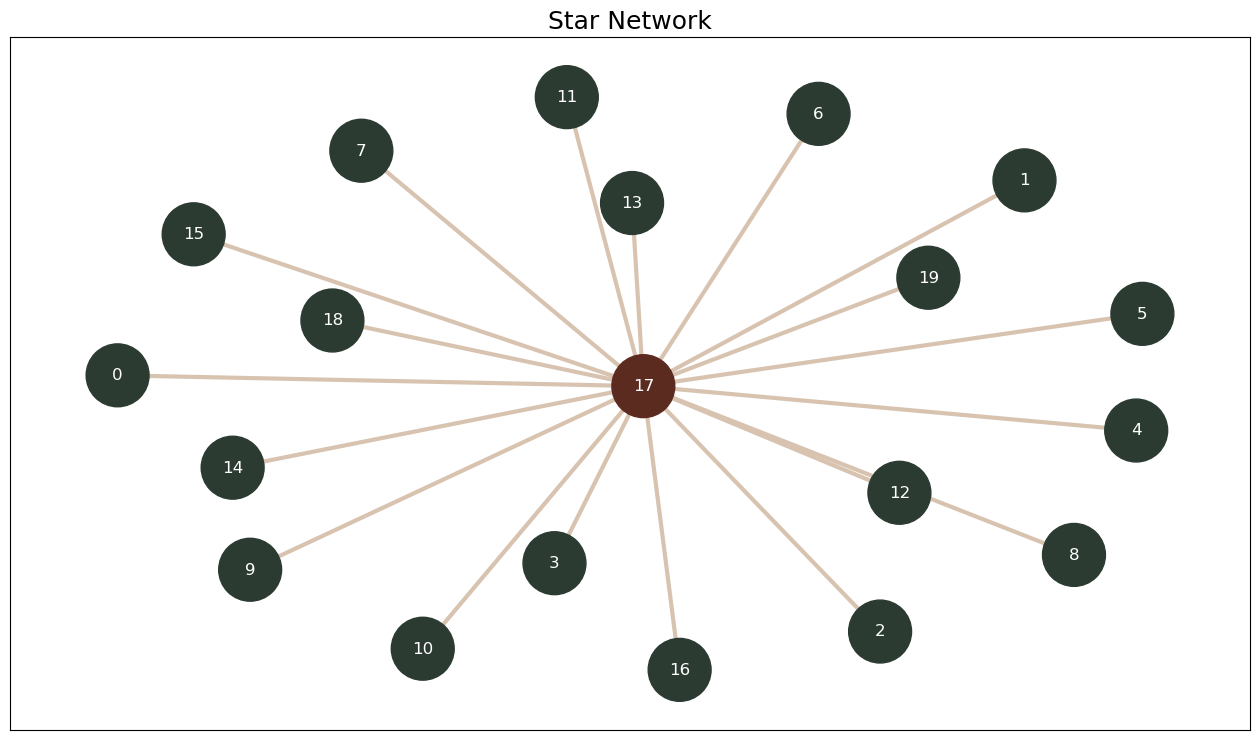

In [4]:
# NBVAL_SKIP
from konnektor.visualization import draw_ligand_network

fig = draw_ligand_network(radial_network, title=radial_network.name)

Now you have seen the basic functionality of Konnektor!

### Cyclic Network Layout
In a next step, let's switch the the network layout. the `CyclicNetworkGenerator` works exactly the same as the `StarNetworkGenerator`, but generates the __Cyclic Network Layout__. This network layout is focusing on generating a graph containing a large set of cycles, which can be useful in free energy calculation for uncertainty estimation of the approach or estimate correction.

In [5]:
from konnektor.network_planners import CyclicNetworkGenerator

network_planner = CyclicNetworkGenerator(mapper=mapper, scorer=combo_scorer)

In [6]:
cyclic_network = network_planner(components)
cyclic_network.name = "Cyclic Network"
cyclic_network

<LigandNetwork-e577ef9e25c47d324b8bd1ffb19313c1>

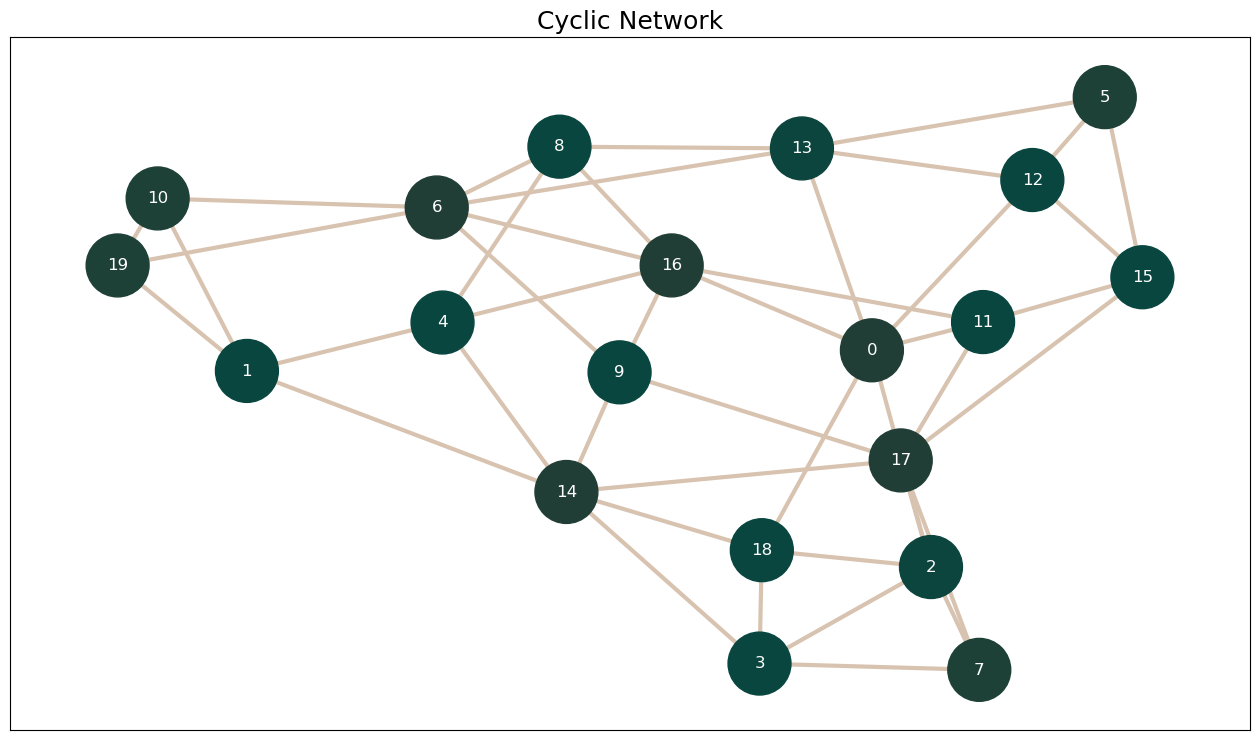

In [7]:
# NBVAL_SKIP
from konnektor.visualization import draw_ligand_network

fig = draw_ligand_network(cyclic_network, title=cyclic_network.name);

### Starry Sky Network Layout
The __Starry Sky Network Layout__ is an extension of the __Star Network Layout__. This network is generated in three steps:
1. Cluster the given list of `Components`
2. In each cluster build a sub-network, here with the __Star Network Layout__.
3. Concatenate the star networks with the two best edges between the clusters.

This Layout tries to circumvent the problem of the sub-optimal compromise finding one molecule that transforms to all others, by selecting a few centers. Therefore the layout is less robust towards edge failure, but optimizes the graph cost better than the __Star Network Layout__ which should lead to less edge failure, if the scoring function is good. 

In [8]:
from konnektor.network_planners import StarrySkyNetworkGenerator

network_planner = StarrySkyNetworkGenerator(mapper=mapper, scorer=combo_scorer)

In [9]:
starry_sky_network = network_planner(components)
starry_sky_network.name = "Starry Sky Network"
starry_sky_network

[20:39:17] DEPRECATION WARNING: please use MorganGenerator
[20:39:17] DEPRECATION WARNING: please use MorganGenerator
[20:39:17] DEPRECATION WARNING: please use MorganGenerator
[20:39:17] DEPRECATION WARNING: please use MorganGenerator
[20:39:17] DEPRECATION WARNING: please use MorganGenerator
[20:39:17] DEPRECATION WARNING: please use MorganGenerator
[20:39:17] DEPRECATION WARNING: please use MorganGenerator
[20:39:17] DEPRECATION WARNING: please use MorganGenerator
[20:39:17] DEPRECATION WARNING: please use MorganGenerator
[20:39:17] DEPRECATION WARNING: please use MorganGenerator
[20:39:17] DEPRECATION WARNING: please use MorganGenerator
[20:39:17] DEPRECATION WARNING: please use MorganGenerator
[20:39:17] DEPRECATION WARNING: please use MorganGenerator
[20:39:17] DEPRECATION WARNING: please use MorganGenerator
[20:39:17] DEPRECATION WARNING: please use MorganGenerator
[20:39:17] DEPRECATION WARNING: please use MorganGenerator
[20:39:17] DEPRECATION WARNING: please use MorganGenerat

<LigandNetwork-c994a1923c58228b181273d074ee15e2>

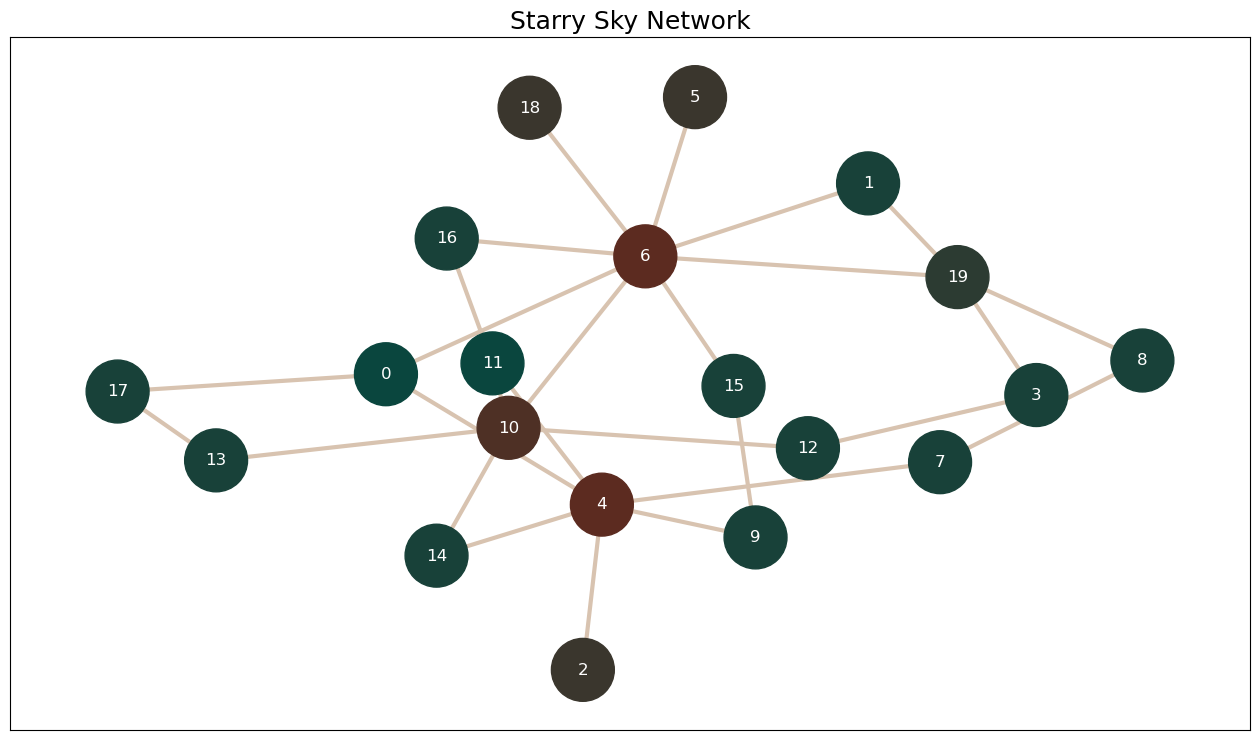

In [10]:
# NBVAL_SKIP
from konnektor.visualization import draw_ligand_network

fig = draw_ligand_network(starry_sky_network, title=starry_sky_network.name);

## 2. Using Real World Data
-------------------------
In the Next example, we will build a Real world case. This translates to use chemical molecules from our Kartograf publication and combine it the Kartograf using it's `AtomMapper` and the `AtomMappingScorer` based on the mapping RMSD

Additionally we will show you here the interactive widget, that gives immediatley insights into the `Component`s and `AtomMapping`s

### First Get Data and build `AtomMapper` and `AtomMappingScorer`

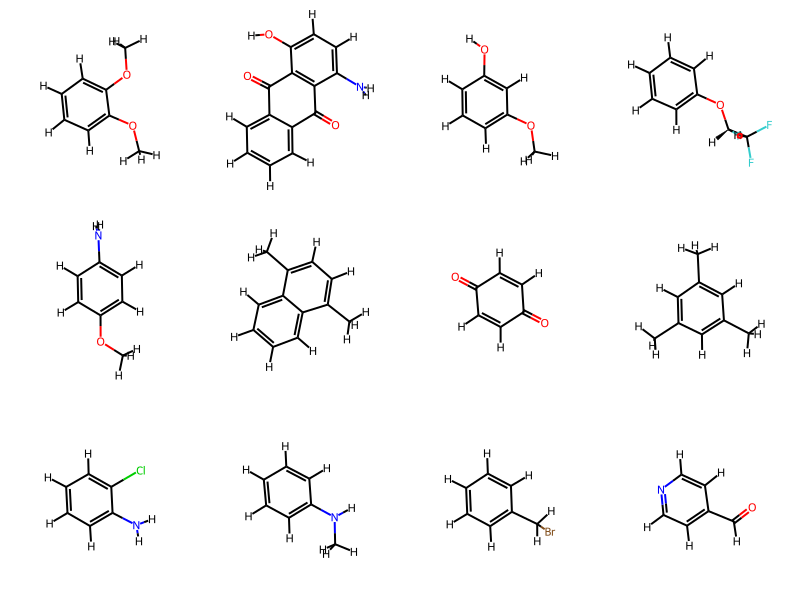

In [11]:
# Getting Data
from rdkit import Chem
from konnektor.data import get_benzene_ligands

rw_components = get_benzene_ligands()
rw_components = list(
    filter(lambda x: not x.name in ["lig_2", "lig_3", "lig_4", "lig_7"], rw_components)
)
Chem.Draw.MolsToGridImage([c.to_rdkit() for c in rw_components], molsPerRow=4)

In [12]:
# Load AtomMapper and Scorer
try:
    from kartograf import KartografAtomMapper, MappingRMSDScorer
except ModuleNotFoundError:  # This will attempt to install kartograf
    !{sys.executable} -m pip install git+https://github.com/OpenFreeEnergy/kartograf.git
    from kartograf import KartografAtomMapper, MappingRMSDScorer

mapper = KartografAtomMapper()
combo_scorer = MappingRMSDScorer()

### Construct __Cyclic Network Layout__
As before, we build the `CyclicNetworkGenerator` passing the `AtomMapper` and `AtomMappingScorer` from Kartograf and use the generator with the components.

In [13]:
from konnektor.network_planners import CyclicNetworkGenerator

network_planner = CyclicNetworkGenerator(
    mapper=mapper, scorer=combo_scorer, n_processes=1
)

cyclic_network_rw = network_planner(rw_components)
cyclic_network_rw.name = "Real World Cyclic Network"
cyclic_network_rw

<LigandNetwork-8d6c43075affce9e3aecc8a2fe6d5866>

In [14]:
# NBVAL_SKIP
from konnektor.visualization import draw_network_widget

draw_network_widget(cyclic_network_rw, show_molecules=True, show_mappings=True);

interactive(children=(Dropdown(description='layout', index=4, options=('dagre', 'cola', 'breadthfirst', 'conce…

## 3. Advanced Network Generation
--------------------------------
After having showed you the basic network generation functionality of Konnektor, let's go beyond that. Konnektor contains a plethora of functions, that can be used to construct, modify or analyse networks.

In the next step we will showcase this functionality by loading a set of potential ligands, that contain a charge change. Our goal here is to build up a network, that is edge efficient but seperates the charges automatically.


### Get Data
First let's load the data:

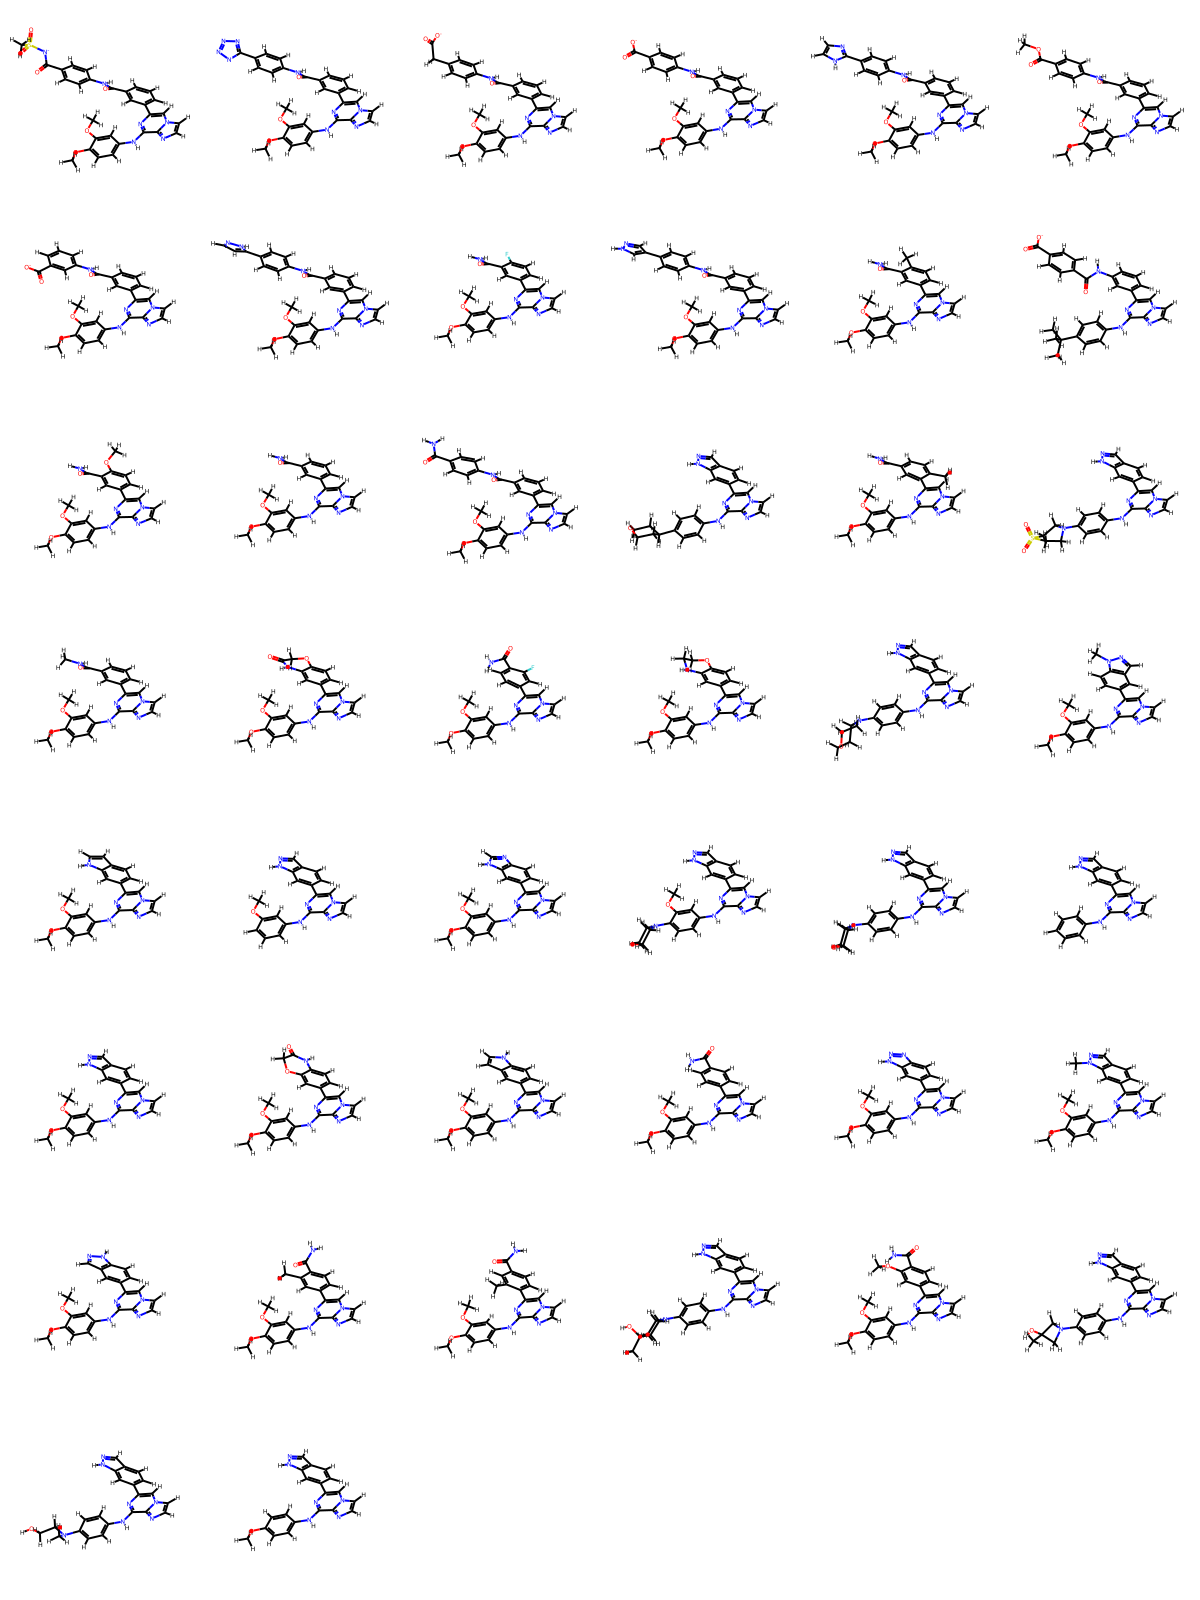

In [15]:
# Getting Data
from rdkit import Chem
from konnektor.data import get_charged_ligands

charge_components = get_charged_ligands()
Chem.Draw.MolsToGridImage([c.to_rdkit() for c in charge_components], molsPerRow=6)

### Generated the Required Scorer
Like with the real world example, we will generate the `AtomMapper` and `AtomMappingScorer` here.

Additionally to the already defined `MappingVolumeRatioScorer` we define here another very simple and crude `charge_scorer`, that captures charge changes and adds a score (please don't use in the real world). We will combine both scores into a `combo_scorer`

In [16]:
# Load AtomMapper and Scorer
try:
    from kartograf import KartografAtomMapper, MappingVolumeRatioScorer
except ModuleNotFoundError:  # This will attempt to install kartograf
    !{sys.executable} -m pip install git+https://github.com/OpenFreeEnergy/kartograf.git
    from kartograf import KartografAtomMapper, MappingVolumeRatioScorer

mapper = KartografAtomMapper()

# Define Scorer Combination
volume_scorer = MappingVolumeRatioScorer()

from gufe import AtomMapping


def charge_scorer(atom_mapping: AtomMapping) -> float:
    mA = atom_mapping.componentA.to_rdkit()
    mB = atom_mapping.componentB.to_rdkit()
    cA = Chem.GetFormalCharge(mA)
    cB = Chem.GetFormalCharge(mB)

    dist = min(1, abs(cA - cB))
    return 1 - dist


def combo_scorer(atom_mapping: AtomMapping) -> float:
    return (1 * volume_scorer(atom_mapping) + 2 * charge_scorer(atom_mapping)) / 3

### Build A Clusterer
Konnektor contains multiple `Clusterer` functions, for seperating `Components` for example by their scaffold, finger print diversity or charge. Here we will use the `ChargeClusterer`, which will help us to seperate the molecules by charge.


In [17]:
# Cluster Compounds by charge:
from konnektor.network_tools import ChargeClusterer

clusterer = ChargeClusterer()
clusters = clusterer.cluster_compounds(components=charge_components)

print("Found charges: ", clusters.keys())

Found charges:  dict_keys([-1, 0])


### Build Sub-Networks
Next we will build sub-networks with each cluster, and visualize them.

In [18]:
# Define Cluster Networks:
from konnektor.network_planners import StarNetworkGenerator

ch_radial_networker = StarNetworkGenerator(mapper=mapper, scorer=combo_scorer)
sub_networks = []
for charge, cluster in clusters.items():
    sub_network = ch_radial_networker(cluster)
    sub_networks.append(sub_network)
used_componentes = [n for sub_network in sub_networks for n in sub_network.nodes]

/tmp/ipykernel_981/4191611991.py:18: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


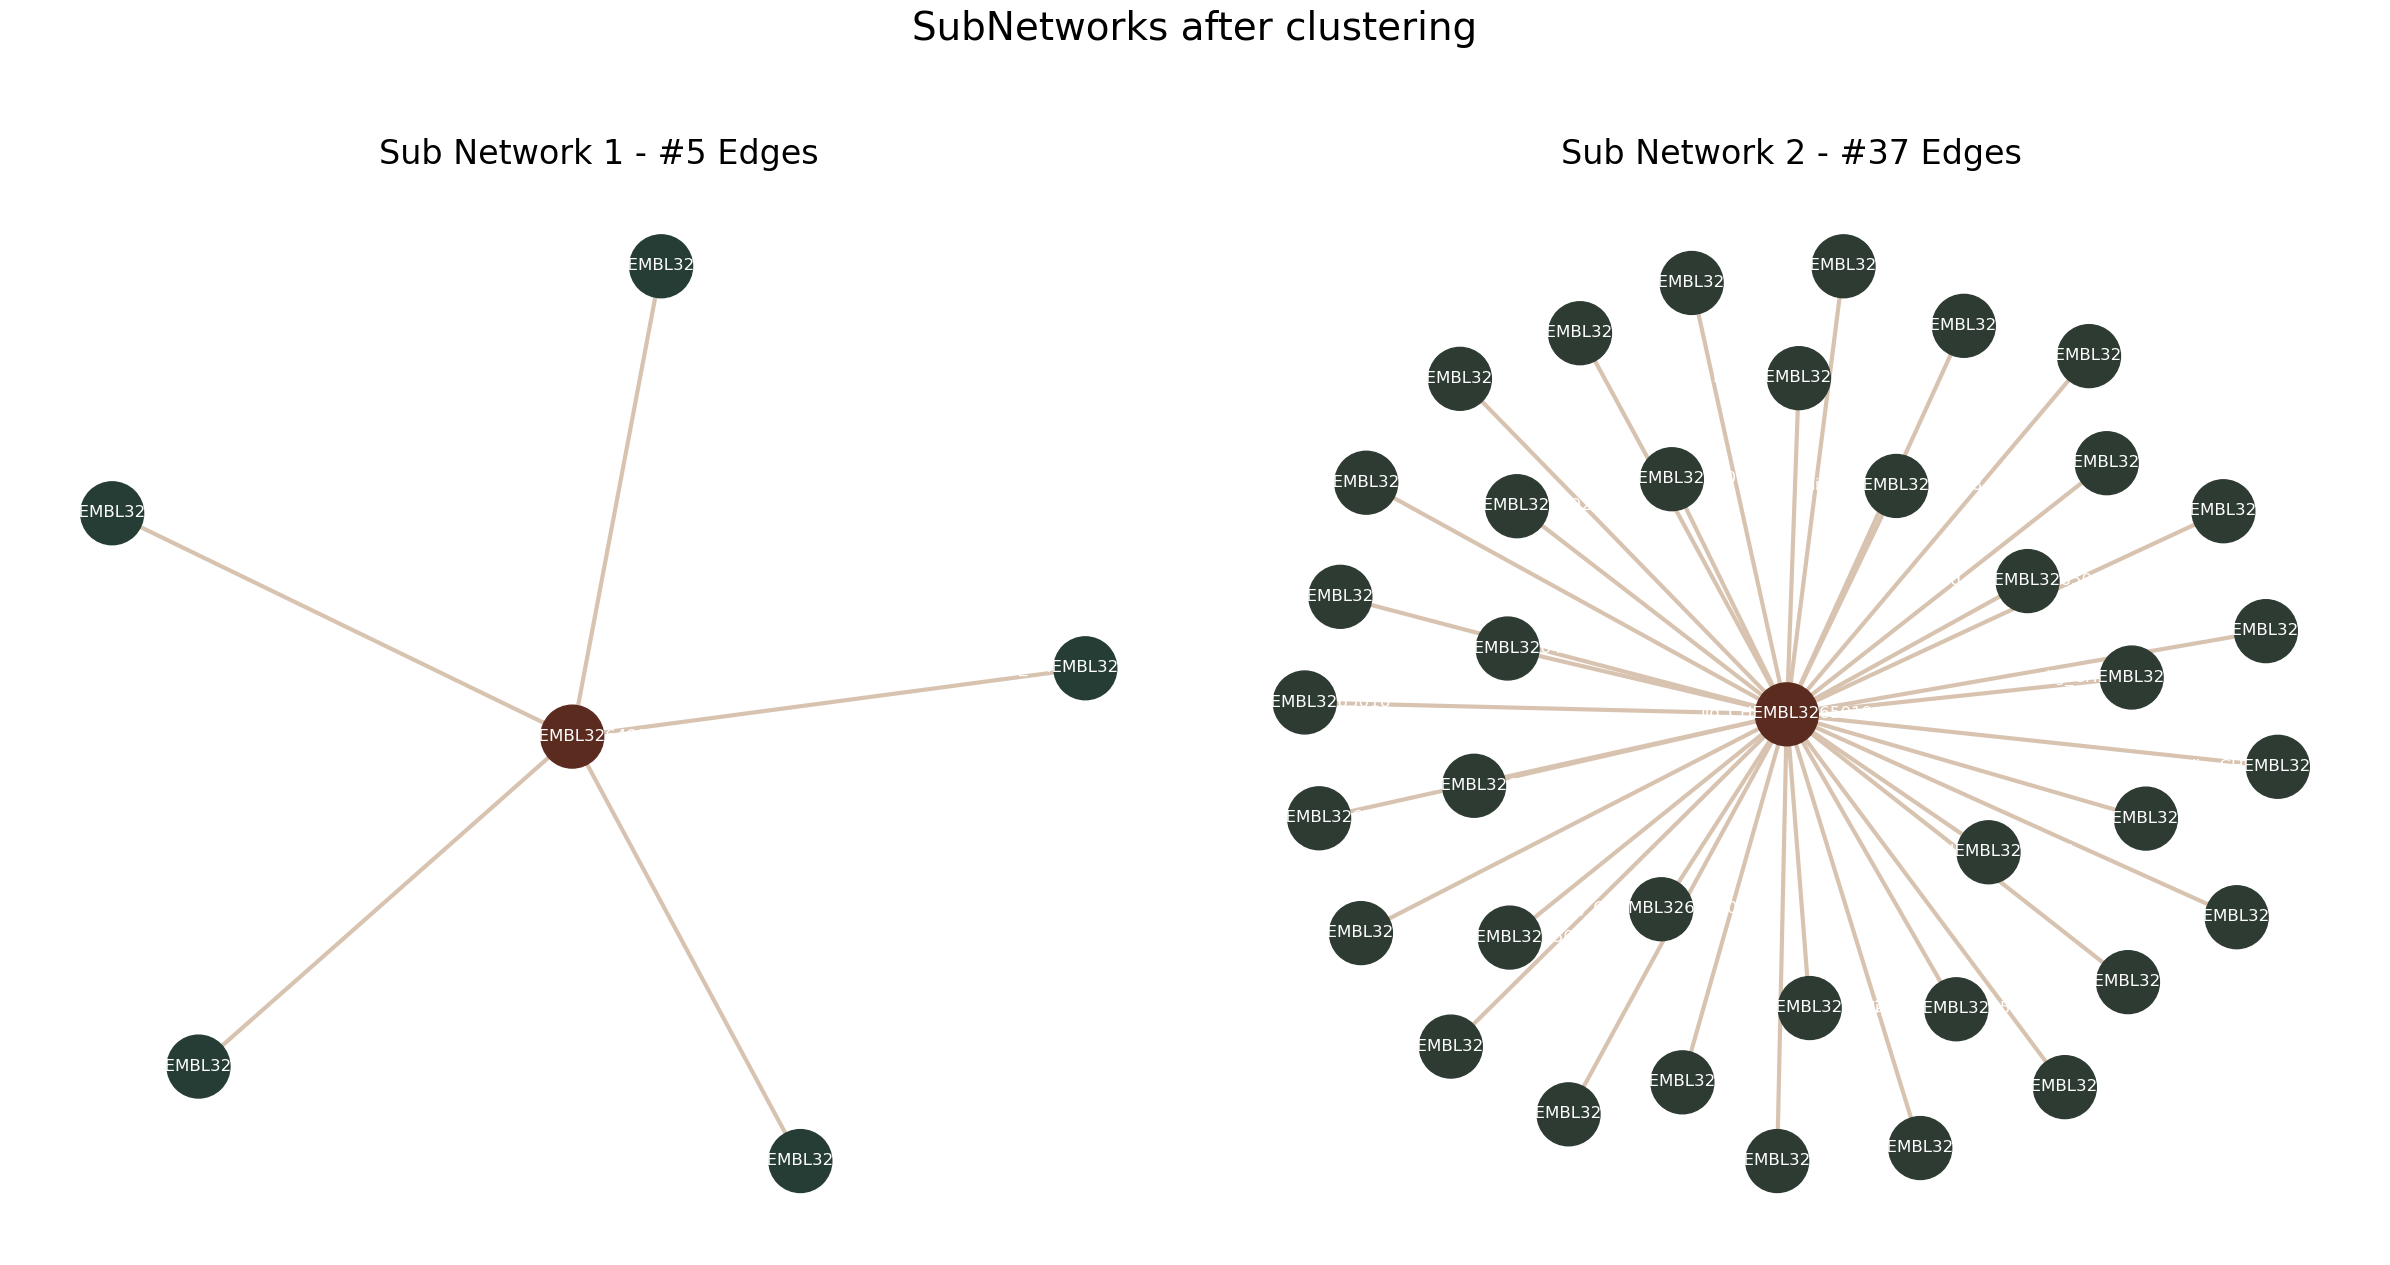

In [19]:
##Visualize sub-networks
from matplotlib import pyplot as plt

fig = plt.figure(layout="constrained", figsize=[12 * 2, 12])
gs0 = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs0[0])
ax2 = fig.add_subplot(gs0[1])

axes = [ax1, ax2]
i = 1
for ax, sub in zip(axes, sub_networks):
    draw_ligand_network(sub, ax=ax)
    ax.set_title(
        "Sub Network " + str(i) + " - #" + str(len(sub.edges)) + " Edges", fontsize=24
    )
    ax.axis("off")
    i += 1

fig.suptitle("SubNetworks after clustering", fontsize=28, y=1.05)
fig.tight_layout()

### Concatenate Sub-Network to Final Network

The final build up will be performed using the concatenate functionality in Konnektor, that allows to concatenate two or more networks.
For this a special network planner is needed the `NetworkConcatenator`, i.e. `MstConcatenator`, which build all possilbe edges between two networks and then selects the best scoring `n_connecting_edges` for building the final network.

In [20]:
## Concatenate Sub-Networks
from konnektor.network_tools import concatenate_networks
from konnektor.network_planners import MstConcatenator

concatenator = MstConcatenator(
    mapper=mapper, scorer=combo_scorer, n_connecting_edges=2, n_processes=1
)

charged_starry_sky_network = concatenate_networks(
    networks=sub_networks, concatenator=concatenator
)
charged_starry_sky_network.name = "Starry Sky Network"
charged_starry_sky_network

<LigandNetwork-ecd00b542d28fff8d6fccf64578f3a5f>

And here it is our __Charged Starry Sky Network__ Layout. In the next cell you can visualize the network. Do you see, how the two clusters are seperating the charge changes from each other and are connected via few edges to bridge the cluster gap?

In [21]:
from konnektor.visualization import draw_network_widget

draw_network_widget(charged_starry_sky_network, show_molecules=True, show_mappings=True);

interactive(children=(Dropdown(description='layout', index=4, options=('dagre', 'cola', 'breadthfirst', 'conce…

### Analyzing the generated network:
In the final step, we will compare the generated __Charged Starry Sky Network__ with alternative network layouts. 

#### Generating Additional Networks to compare to.
For our comparison we will generate a global __Star Network__ and a __Redundant MST Network__.


In [22]:
# first let's generate the Star Network (we will use the networker from above).
ch_radial_networker = StarNetworkGenerator(
    mapper=mapper, scorer=combo_scorer, n_processes=5
)
charge_star_network = ch_radial_networker(used_componentes)
charge_star_network.name = "Star Network"

# And additionally the Cyclic Network
from konnektor.network_planners import RedundantMinimalSpanningTreeNetworkGenerator

ch_rmst_networker = RedundantMinimalSpanningTreeNetworkGenerator(
    mapper=mapper, scorer=combo_scorer, n_processes=5, n_redundancy=2
)
charge_rmst_network = ch_rmst_networker(used_componentes)
charge_rmst_network.name = "Redundant MST Network"

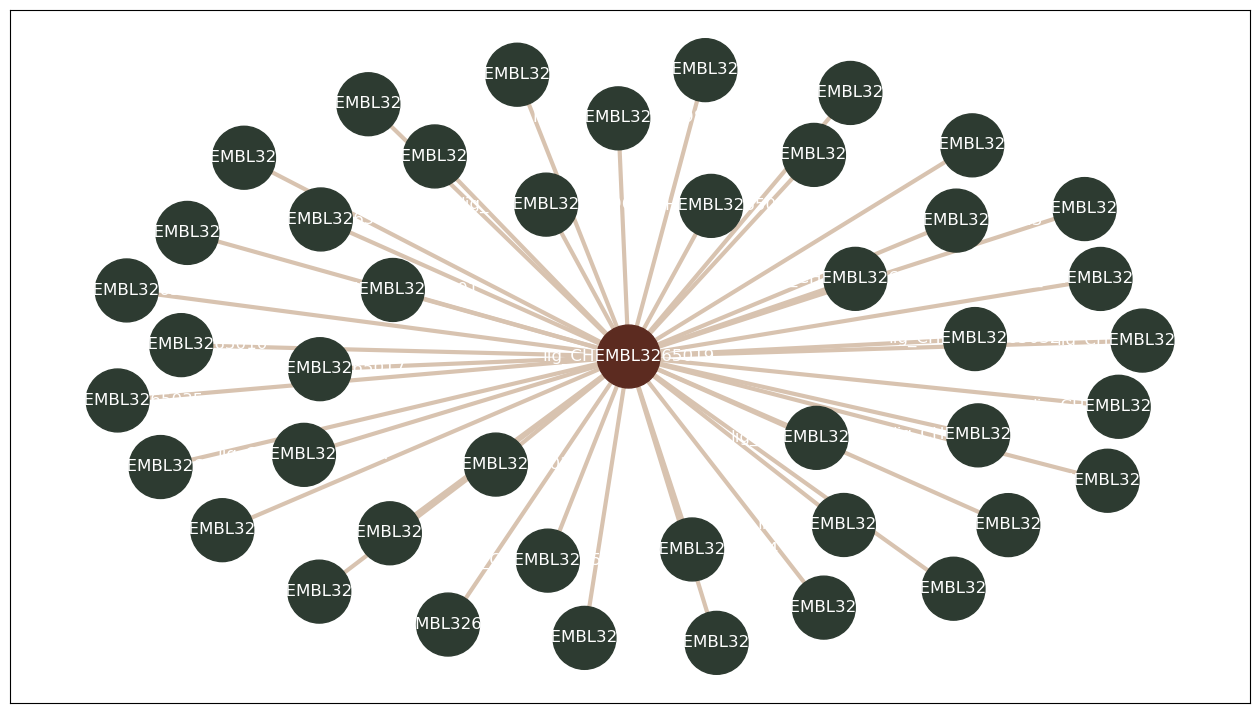

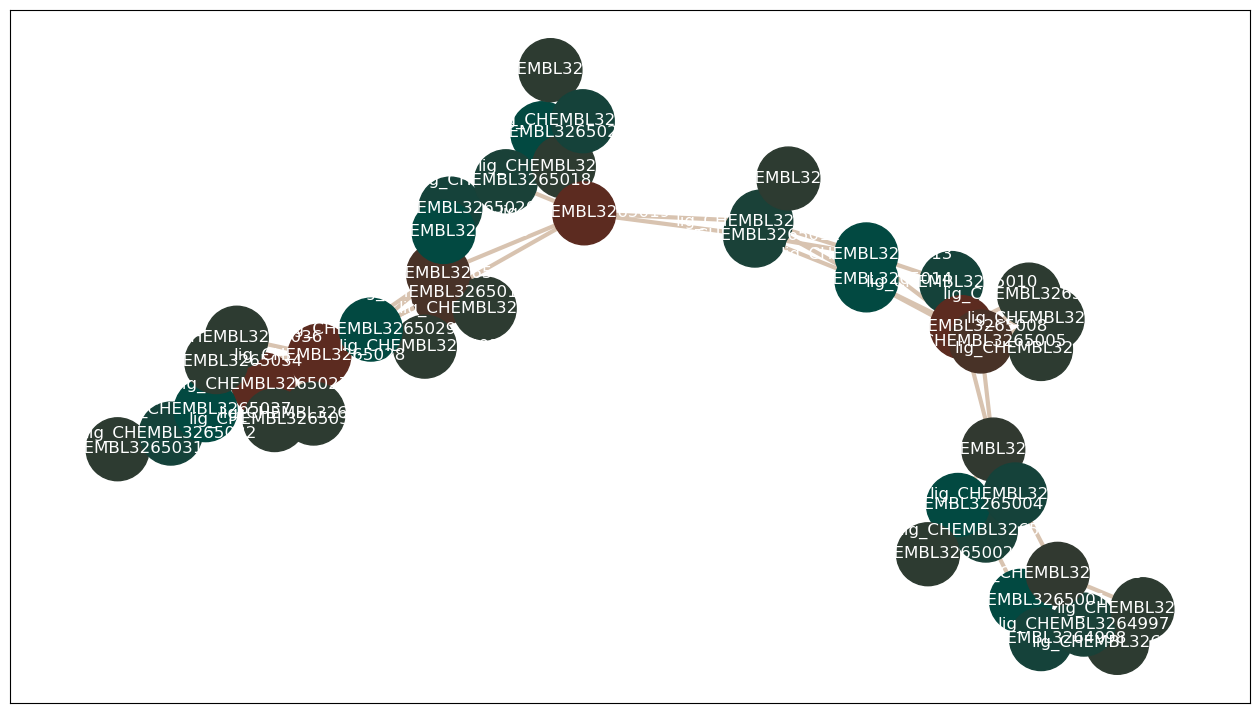

In [23]:
from konnektor.visualization import draw_ligand_network

draw_ligand_network(
    charge_star_network,
)
draw_ligand_network(
    charge_rmst_network,
);

#### Compare Networks
The comparison will be done using the implemented analysis functions in Konnektor. 
First, we will test if the resulting network __is connected__, translating to each `Component` is somehow connected with each other `Component`.
Next we count the __number of edges__, that the network contains and the __number of cycles__ in the graph, which if of interest for uncertainty estimates or free energy estimate corrections. 

The __graph cost__ is a distances, that is generated from adding up all edge scores like $\sum^N_i 1-s^i_e$. This metric gives insights over the overall difficulty of calculating all transformations in a network. The larger a cost is, the harder it should be to good free energy estimates, if the scoring function is performing reasonably.

Last the __graph robustness__ test if the connectedness gets lost after removing $1\%$ of the planned transformations. This is done by removing randomly $1%$ of the edges, evaluating if the graph is still connected and repeating this for 100 times, giving a ratio of how often the graph was still connected.

In [24]:
import numpy as np
from konnektor.network_analysis.network_analysis import (
    get_graph_cost,
    get_is_connected,
    get_number_of_graph_cycles,
    get_node_connectivities,
    get_edge_failure_robustness,
)

networks = [charge_star_network, charged_starry_sky_network, charge_rmst_network]

header_format_str = "|{:<30}|{:>22}|{:>22}|{:>22}|"
format_str = "|{:<30}|{:>22.2f}|{:>22.2f}|{:>22.2f}|"

table_str = header_format_str.format("Metric", *[n.name for n in networks]) + "\n"
table_str += header_format_str.format("-" * 30, "-" * 22, "-" * 22, "-" * 22) + "\n"
table_str += (
    header_format_str.format(
        "is connected", *[str(get_is_connected(n)) for n in networks]
    )
    + "\n"
)
table_str += (
    header_format_str.format("number of edges", *[len(n.edges) for n in networks])
    + "\n"
)
table_str += (
    header_format_str.format(
        "number of graph cycles",
        *[int(get_number_of_graph_cycles(n)) for n in networks],
    )
    + "\n"
)
table_str += (
    format_str.format(
        "average node connectivity",
        *[np.mean(list(get_node_connectivities(n).values())) for n in networks],
    )
    + "\n"
)
table_str += (
    format_str.format("graph cost", *[get_graph_cost(n) for n in networks]) + "\n"
)
table_str += (
    format_str.format(
        "graph robustness",
        *[get_edge_failure_robustness(n, failure_rate=0.01) for n in networks],
    )
    + "\n"
)

from IPython.display import display, Markdown, Latex

display(Markdown(table_str))

|Metric                        |          Star Network|    Starry Sky Network| Redundant MST Network|
|------------------------------|----------------------|----------------------|----------------------|
|is connected                  |                  True|                  True|                  True|
|number of edges               |                    43|                    44|                    86|
|number of graph cycles        |                     0|                     0|                    41|
|average node connectivity     |                  1.95|                  2.00|                  3.91|
|graph cost                    |                  8.41|                  5.26|                  5.68|
|graph robustness              |                  0.00|                  0.05|                  1.00|


In our comparison the __Star Network__ and the __Starry Sky Network__ have a similar *number of edges* and significantly less compared to the __Redundant MST Network__. If all transformations can be calculated succesfully in the first go, this would translate to significantly less calculation effort using the __Star Network__ and the __Starry Sky Network__. However the *graph cost* for the __Star Network__ is significantly larger compared to the __Starry Sky Network__ and the similarly perfomring __Cyclic Network__. This indicates that the danger of edges failing is potentially larger for the __Star Network__, if the scoring metric is reasonable.

The consequence of a edge failure can be deduced from the *graph robustness*, for the  __Star Network__ any edge failure leads to the same amount of `Component`s lost in the final ranking. The __Starry Sky Network__ seems to recover from an $1\%$ edge loss to about ~ 10% of the cases, which does not make it a very robust approach either. Only the __Redundant MST Network__ is able to withstand the $1\%$ edge failure without losing any `Component` in the final ranking. This robustness is an effect from the high *average node connectivity* of the __Redundant MST Network__. An additional interesting aspect of the __Redundant MST Network__ is the large generated number of cycles, which can be used for advanced analysis of the final free energy calculation results.

A larger comparison of Networks can be found in our pre-print: ![]()
